# Progowanie komórek na zdjęciach w odcieniach szarości

#### Importowanie bibliotek

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

#### Dodanie funkcji odpowiedzialnych za wyświetlanie obrazów i histogramów.

In [2]:
def show_image(image, title=""):
    if image.ndim == 2:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.title(title)

In [3]:
def show_histogram(image):
    plt.figure(figsize=(10,5), dpi=80)
    plt.subplot(1,2,1)
    show_image(image)
    plt.subplot(1,2,2)
    histogram = cv2.calcHist([image],[0],None,[256],[0,256])
    plt.plot(histogram)
    plt.xlim([0,256])
    plt.show()

#### Wczytanie obrazów

Zostaną wczytane 4 obrazy, każdy o nieco innych cechach.
* Obraz nr 1 zawiera mało komórek, które są oddalone od siebie.
* Obraz nr 2 zawiera nieco więcej komórek, między którymi dystans jest mniejszy, niż w przypadku obrazu nr 1.
* Obraz nr 3 zawiera dużo komórek o mniejszych rozmiarach, w porównaniu do poprzednich obrazów.
* Obraz nr 4 zawiera bardzo dużo komórek, które są bardzo trudne do wysegmentowania.

W przypadku obrazu nr 2 oraz obrazu nr 3, możemy zauważyć komórki, które są położone bardzo blisko siebie, co może powodować ich połączenie.

In [4]:
image_1 = cv2.imread('../grey_images/0acd2c223d300ea55d0546797713851e818e5c697d073b7f4091b96ce0f3d2fe.png', cv2.CV_8UC1)
image_2 = cv2.imread('../grey_images/0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9.png', cv2.CV_8UC1)
image_3 = cv2.imread('../grey_images/1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5.png', cv2.CV_8UC1)
image_4 = cv2.imread('../grey_images/0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1.png', cv2.CV_8UC1)

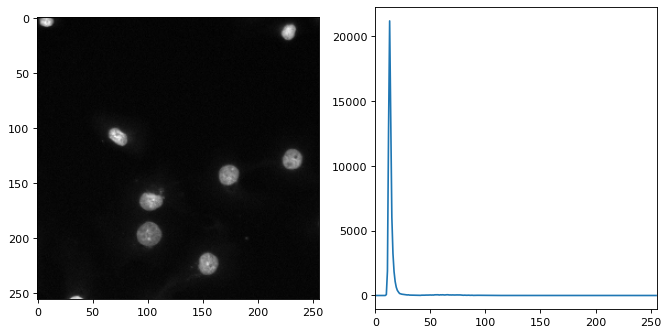

Threshold =  40.0


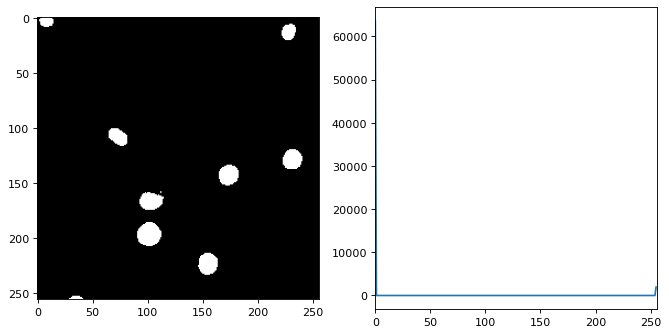

In [5]:
show_histogram(image_1)
threshold_1, otsu_1 = cv2.threshold(image_1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Threshold = ", threshold_1)
show_histogram(otsu_1)

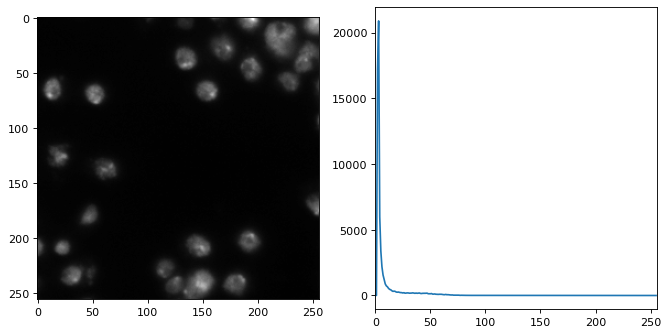

Threshold =  25.0


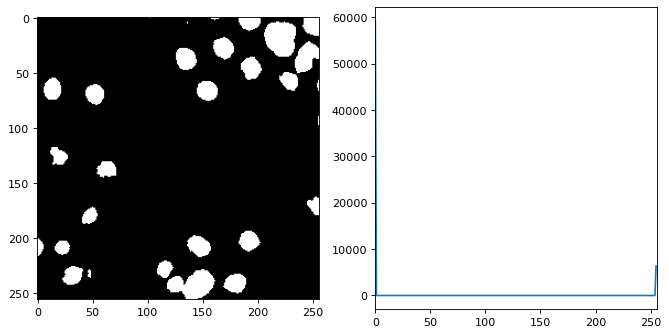

In [6]:
show_histogram(image_2)
threshold_2, otsu_2 = cv2.threshold(image_2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Threshold = ", threshold_2)
show_histogram(otsu_2)

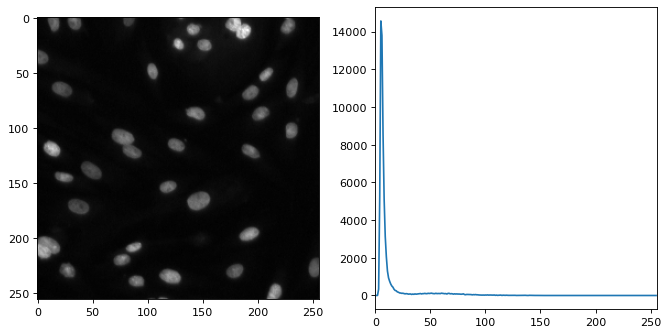

Threshold =  38.0


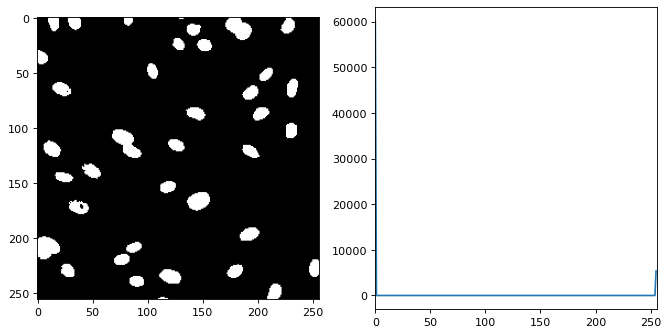

In [7]:
show_histogram(image_3)
threshold_3, otsu_3 = cv2.threshold(image_3, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Threshold = ", threshold_3)
show_histogram(otsu_3)

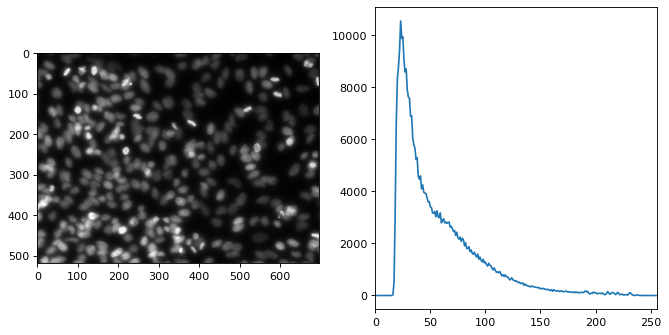

Threshold =  73.0


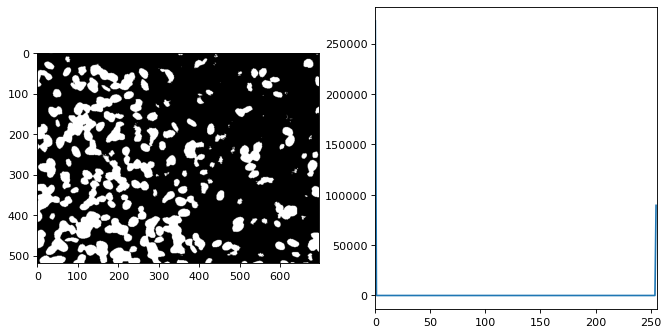

In [8]:
show_histogram(image_4)
threshold_4, otsu_4 = cv2.threshold(image_4, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Threshold = ", threshold_4)
show_histogram(otsu_4)

##### Podsumowanie I
W przypadku obrazu nr 1 progowanie wypadło bardzo dobrze. W przypadku obrazu nr 2 możemy zauważyć brak wysegmentowanej komórki na górze obrazu oraz dwukrotne połączenie dwóch komórek w jedną. Podobna sytuacja ma miejsce w przypadku obrazu nr 3, gdzie możemy zaobserwować trzy takie przypadki. Ostatni obraz pokazuje, że metoda progowania Otsu nie jest dostoswana do takich przypadków. Ostatni przypadek wyróżnia się na tle pozostałych, ze względu na jego specyfikę, która doskonale jest odwzorowana na histogramie (bardzo dużo komórek o różnym poziomie jasności). Na początku, prace zostaną skupione na obrazach, takich jak 3 pierwsze przypadki.

#### Binaryzacja z uwzględnieniem innych operacji

In [9]:
kernel_1 = np.array([[-1, -1, -1],[-1, 9, -1],[-1, -1, -1]])
sharpened_image = cv2.filter2D(image_2, -1, kernel_1)

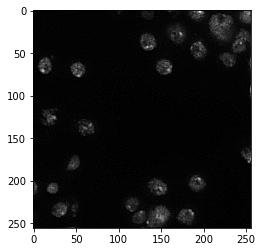

In [10]:
show_image(sharpened_image)

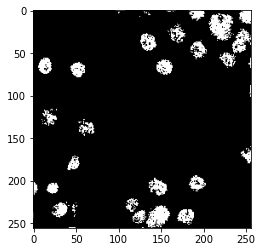

In [11]:
threshold_5, otsu_5 = cv2.threshold(sharpened_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show_image(otsu_5)

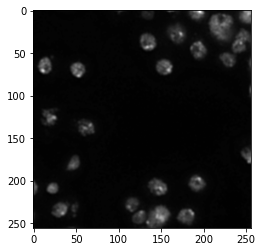

In [12]:
gauss = cv2.GaussianBlur(sharpened_image, (5, 5), 0)
show_image(gauss)

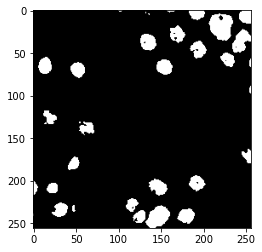

In [13]:
threshold_6, otsu_6 = cv2.threshold(gauss, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show_image(otsu_6)

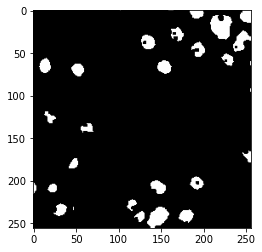

In [14]:
kernel_2 = np.ones((3,3), np.uint8)
eroded_image = cv2.erode(otsu_6, kernel_2)
show_image(eroded_image)

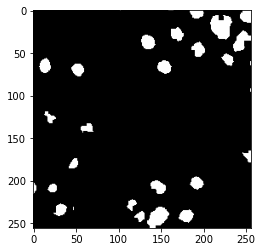

In [15]:
closed_image = cv2.morphologyEx(eroded_image, cv2.MORPH_CLOSE, kernel_2, iterations = 2)
show_image(closed_image)

#### Podsumowanie II
Drugi etap pozwolił na uzyskanie lepszych wyników, niż w przypadku samej binaryzacji Otsu. Kluczowym czynnikiem było wyostrzenie obrazu, co poprawiło wyniki w przypadkach, gdzie komórki są położone bardzo blisko siebie, lecz nie są złączone. Samo wyostrzenie pozostawia bardzo dużo czarnych pikseli wewnątrz komórek, dlatego w kolejnym kroku, obraz został przetworzony za pomocą filtru Gaussa, dzięki czemu uzyskaliśmy większe rozmycie wewnątrz komórek. Na przetworzonym tak obrazie została wykonana binaryzacja metodą Otsu. Następnie, została wykonana operacja erozji, a w kolejnym kroku zostało wykonane zamknięcie (2 iteracje). Dwie ostatnie operacje pozwoliły usunąć czarne piksele (obszary) z komórek, natomiast istotnie przyczyniły się do ich zmniejszenia.